# 【第三次讀書會】
- **Author: 池品叡**
- 日期：2024/05/07
- 範圍：
  * week10
  * week11

# 1st. 主題模型
```python

## 0. 資料及說明
### *資料來源*

1. 聯合新聞網 (udn)
> 目前的資料筆數約為 6000 筆，是由於 TarFlow 平台的爬蟲筆數限制（<=10000）。

### *新聞類別*
* 【運動】
* 【社會】
* 【全球】
* 【產經】
* 【股市】
* 【兩岸】


## 1. 套件說明

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

*`Logging Package`*
在進行主題模型的訓練時，我們會使用到 logging package 來顯示訓練的進度，這邊我們先設定 logging 的等級為 INFO，讓訓練過程中可以看到訓練的進度。

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 2. 資料前處理

In [4]:
udn = pd.read_csv("raw_data/udn.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,湯普森樂於接受替補地位 或許是長留勇士的生存之道,2024-03-01 07:00:00,運動,https://udn.com/news/story/122629/7801017,湯普森(Klay Tompson)近期連續五場球被勇士教練團降為替補，這也是他打從新人年以來...,NaN,UDN
1,2,日職／大聯盟之夢想圓滿 村上宗隆近兩季須達成業績,2024-03-04 07:00:00,運動,https://udn.com/news/story/122629/7806019,剛打完台灣遠征比賽的讀賣巨人，返回日本之後準備迎接官辦熱身賽，為2024年例行賽之前做最後備...,NaN,UDN
2,3,洋基第一棒該派誰打？ 索托或許才是最佳人選,2024-03-04 07:00:00,運動,https://udn.com/news/story/122629/7806063,誰是洋基隊史上最偉大的開路先鋒？頭一個會想到的八成是「隊長」基特（Derek Jeter）。...,NaN,UDN


In [5]:
# manipulate data columns
udn['artContent'] = udn['artUrl']
udn = udn.drop(columns=['system_id', 'artSecondCatagory', 'dataSource'])
# 篩掉不需要的分類
cat2drop = ['要聞', '生活']
udn = udn[~udn['artCatagory'].isin(cat2drop)]

In [6]:
# 檢查目前類別
udn['artCatagory'].unique()

array(['運動', '全球', '社會', '產經', '股市', '兩岸'], dtype=object)

In [7]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,湯普森近期連續五場球被勇士教練團降為替補這也是他打從新人年以來首度從板凳出發據統計湯普森此前...,湯普森(Klay Tompson)近期連續五場球被勇士教練團降為替補，這也是他打從新人年以來...,運動,2024-03-01 07:00:00
1,剛打完台灣遠征比賽的讀賣巨人返回日本之後準備迎接官辦熱身賽為年例行賽之前做最後備戰巨人軍想要...,剛打完台灣遠征比賽的讀賣巨人，返回日本之後準備迎接官辦熱身賽，為2024年例行賽之前做最後備...,運動,2024-03-04 07:00:00
2,誰是洋基隊史上最偉大的開路先鋒頭一個會想到的八成是隊長基特不過基特其實是在年過的生涯第個球季...,誰是洋基隊史上最偉大的開路先鋒？頭一個會想到的八成是「隊長」基特（Derek Jeter）。...,運動,2024-03-04 07:00:00


In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /Users/raychi/Desktop/code/SA/handedin/第三組_HW3/dict/dict.txt.big ...
2024-05-06 10:36:11,794 : DEBUG : Building prefix dict from /Users/raychi/Desktop/code/SA/handedin/第三組_HW3/dict/dict.txt.big ...
Dumping model to file cache /var/folders/q3/g1qdy2wx5r1582rn40qsrsg40000gn/T/jieba.uf814682fbd598f7dfa57ce9b3f4db538.cache
2024-05-06 10:36:12,180 : DEBUG : Dumping model to file cache /var/folders/q3/g1qdy2wx5r1582rn40qsrsg40000gn/T/jieba.uf814682fbd598f7dfa57ce9b3f4db538.cache
Loading model cost 0.422 seconds.
2024-05-06 10:36:12,216 : DEBUG : Loading model cost 0.422 seconds.
Prefix dict has been built successfully.
2024-05-06 10:36:12,217 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,湯普森近期連續五場球被勇士教練團降為替補這也是他打從新人年以來首度從板凳出發據統計湯普森此前...,湯普森(Klay Tompson)近期連續五場球被勇士教練團降為替補，這也是他打從新人年以來...,運動,2024-03-01 07:00:00,"[湯普森, 近期, 連續, 五場, 勇士, 教練, 團降, 替補, 這也, 新人, 以來, ..."
1,剛打完台灣遠征比賽的讀賣巨人返回日本之後準備迎接官辦熱身賽為年例行賽之前做最後備戰巨人軍想要...,剛打完台灣遠征比賽的讀賣巨人，返回日本之後準備迎接官辦熱身賽，為2024年例行賽之前做最後備...,運動,2024-03-04 07:00:00,"[剛打, 完台灣, 遠征, 比賽, 讀賣, 巨人, 返回, 日本, 之後, 準備, 迎接, ..."
2,誰是洋基隊史上最偉大的開路先鋒頭一個會想到的八成是隊長基特不過基特其實是在年過的生涯第個球季...,誰是洋基隊史上最偉大的開路先鋒？頭一個會想到的八成是「隊長」基特（Derek Jeter）。...,運動,2024-03-04 07:00:00,"[洋基隊, 史上, 偉大, 開路先鋒, 想到, 隊長, 基特, 基特, 年過, 生涯, 第個..."
3,近期媒體報導樂天桃猿教練團計畫將先發投手曾仁和轉調牛棚陳冠宇自請重回先發老實說這樣的安排風險...,近期媒體報導，樂天桃猿教練團計畫將先發投手曾仁和轉調牛棚，陳冠宇自請重回先發，老實說，這樣的...,運動,2024-03-04 07:00:00,"[近期, 媒體, 報導, 樂天, 桃猿, 教練, 團計, 畫將, 先發, 投手, 仁和, 轉..."
4,撰文石毓琪四年前職業棒球雜誌於球春到來開季春訓特輯封面放上時任隊總教練快轉個球季只剩下近年摘...,【撰文・石毓琪】四年前《職業棒球》雜誌於〈球春到來 開季春訓特輯〉封面放上時任5隊總教練，快...,運動,2024-03-06 12:00:00,"[撰文, 石毓琪, 四年, 職業, 棒球, 雜誌, 球春, 到來, 開季, 春訓, 特輯, ..."


In [9]:
udn.groupby(['artCatagory']).size()

artCatagory
全球    1218
兩岸     751
產經    1308
社會    1048
股市    1095
運動     567
dtype: int64

## 3. Lexicon-based / 人工給定主題的主題模型

In [10]:
# 根據 6 個主題給予領域的相關詞彙
custom_topic_word = {
    "運動": [
        "棒球",
        "職棒",
        "比賽",
        "賽事",
        "球員",
        "預賽",
        "投手",
        "戰績",
        "球隊",
        "賽程",
        "球迷",
        "選手",
        "大聯盟",
        "春訓",
        "分組",
        "先發",
        "比分",
        "安打",
        "大谷",
        "大谷翔平",
        "聯盟",
        "冠軍",
        "打擊",
        "球團"
    ],
    "股市": [
        '指數',
        '台股',
        '市場',
        '投資',
        '美國',
        '上漲',
        '投資人',
        '股價',
        '表現',
    ],
    "社會": [
        "表示", "警方", "今天", "男子", "發現", "發生", "記者", "萬元", "報導", "指出"
    ],
    "產經": [
        "中國",
        "大陸",
        "兩岸",
        "習近平",
        "北京",
        "人民幣",
        "中共",
        "上海",
        "國務院",
        "李強",
        "華為",
        "政協",
        "兩會",
    ],
    "全球": [
        "中國", "表示", "大陸", "台灣", "發展", "工作", "國家", "政府", "指出", "美國"
    ],
    '兩岸': [
        '中國',
        '大陸',
        '兩岸',
        '習近平',
        '北京',
        '台灣',
        '國台辦',
        '國民黨',
        '民進黨',
        '台北',
        '香港',
        '國家',
        '政府',
        '中共',
        '台商',
        '兩會',
        '中央',
        '政治',
        '政策',
        '國際',
        '問題',
    ]
}

In [11]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [12]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [13]:
df_count = pd.DataFrame({})
# key: topic name, value: topic words
# np.isin() to check if the word is in the feature_names
# 輸出的結果是一個布林值的陣列，代表著該元素是否在另一個陣列中
# 選出符合的詞彙，並計算出現次數
# udn_matrix[:, idx] 取出符合的詞彙
# sum(axis=1) 計算次數
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count.head()

,topic_運動,topic_股市,topic_社會,topic_產經,topic_全球,topic_兩岸
0,19,3,1,0,0,0
1,26,1,0,0,1,3
2,24,8,3,0,2,0
3,35,6,2,0,2,4
4,66,10,4,0,20,9


計算每個文件的主題分布（normalized）

In [14]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_運動,topic_股市,topic_社會,topic_產經,topic_全球,topic_兩岸
0,0.826087,0.130435,0.043478,0.0,0.000000,0.000000
1,0.838710,0.032258,0.000000,0.0,0.032258,0.096774
2,0.648649,0.216216,0.081081,0.0,0.054054,0.000000
3,0.714286,0.122449,0.040816,0.0,0.040816,0.081633
4,0.605505,0.091743,0.036697,0.0,0.183486,0.082569


In [15]:
# 確認資料筆數
thetas.index.stop

5987

## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

**4.1 正式處理新聞**

In [16]:
docs = udn['words'].to_list()
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.7)
print(dictionary)

2024-05-06 10:36:25,589 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


2024-05-06 10:36:26,039 : INFO : built Dictionary<87594 unique tokens: ['一世', '一員', '一場', '一敗', '一環']...> from 5987 documents (total 1234689 corpus positions)
2024-05-06 10:36:26,040 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<87594 unique tokens: ['一世', '一員', '一場', '一敗', '一環']...> from 5987 documents (total 1234689 corpus positions)", 'datetime': '2024-05-06T10:36:26.040296', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 15:27:52) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}
2024-05-06 10:36:26,068 : INFO : discarding 67941 tokens: [('一世', 4), ('一敗', 2), ('二當家', 1), ('五六年', 1), ('五場', 4), ('令人尊敬', 2), ('以先', 1), ('倚老賣老', 1), ('別件', 1), ('加圖', 1)]...
2024-05-06 10:36:26,069 : INFO : keeping 19653 tokens which were in no less than 5 and no more than 4190 (=70.0%) documents
2024-05-06 10:36:26,085 : INFO : resulting dictionary: Dictionary<19653 unique tokens: ['一員', '一場', '一環', '一直', '一股']...>


Dictionary<19653 unique tokens: ['一員', '一場', '一環', '一直', '一股']...>


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>



### 建立語料庫(corpus)及字典(dictionary)

In [17]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

`LdaModel()`
+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈


+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

> `NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

In [18]:
model_6 = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_6, corpus, dictionary)
p

2024-05-06 10:36:26,328 : INFO : using symmetric alpha at 0.14285714285714285
2024-05-06 10:36:26,329 : INFO : using symmetric eta at 0.14285714285714285
2024-05-06 10:36:26,330 : INFO : using serial LDA version on this node
2024-05-06 10:36:26,335 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 5987 documents, updating model once every 2000 documents, evaluating perplexity every 5987 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 10:36:26,335 : INFO : PROGRESS: pass 0, at document #2000/5987
2024-05-06 10:36:26,762 : INFO : merging changes from 2000 documents into a model of 5987 documents
2024-05-06 10:36:26,766 : INFO : topic #4 (0.143): 0.009*"表示" + 0.007*"今天" + 0.005*"美國" + 0.004*"今年" + 0.004*"拜登" + 0.004*"報導" + 0.003*"去年" + 0.003*"公司" + 0.003*"巨蛋" + 0.003*"總統"
2024-05-06 10:36:26,766 : INFO : topic #6 (0.143): 0.008*"美國" + 0.006*"中國" + 0.006*"表示" + 0.005*"今天" + 0.005*"以色列" + 0.004*"台灣" + 0.004*"報導" + 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.087822  0.000418       1        1  23.402379
6     -0.030032 -0.181958       2        1  18.648590
0      0.230465  0.109849       3        1  14.158879
1      0.207846  0.071276       4        1  13.755304
2     -0.208376  0.021177       5        1  11.604135
4     -0.007697 -0.172707       6        1   9.810538
5     -0.280028  0.151945       7        1   8.620174, topic_info=      Term         Freq        Total Category  logprob  loglift
1859    中國  5223.000000  5223.000000  Default  30.0000  30.0000
4693    億元  4061.000000  4061.000000  Default  29.0000  29.0000
2761    警方  1754.000000  1754.000000  Default  28.0000  28.0000
12514   營收  2091.000000  2091.000000  Default  27.0000  27.0000
90      市場  3597.000000  3597.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
2713    協助   219.880258   780.675636   Topic7  -6.0655   1.1840
4973    安全   232.164733  1437.939021   Topic7  -6.0112   0.6275
10815   檢方   202.563644   455.400549   Topic7  -6.1476   1.6409
316     前往   203.425423   495.354536   Topic7  -6.1433   1.5611
531     指出   220.953760  3397.744153   Topic7  -6.0607  -0.2818

[581 rows x 6 columns], token_table=       Topic      Freq Term
term                       
656        1  0.016705   一名
656        2  0.143661   一名
656        3  0.003341   一名
656        4  0.011693   一名
656        5  0.474414   一名
...      ...       ...  ...
17501      4  0.996386   高息
15730      5  0.977633  高虹安
15730      7  0.012534  高虹安
15410      5  0.980655   高院
13509      4  0.994786   點收

[1646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 1, 2, 3, 5, 6])

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [19]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2024-05-06 10:36:35,393 : INFO : using symmetric alpha at 0.5
2024-05-06 10:36:35,394 : INFO : using symmetric eta at 0.5
2024-05-06 10:36:35,395 : INFO : using serial LDA version on this node
2024-05-06 10:36:35,397 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 5987 documents, updating model once every 2000 documents, evaluating perplexity every 5987 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 10:36:35,397 : INFO : PROGRESS: pass 0, at document #2000/5987
2024-05-06 10:36:35,814 : INFO : merging changes from 2000 documents into a model of 5987 documents
2024-05-06 10:36:35,816 : INFO : topic #0 (0.500): 0.009*"美國" + 0.008*"表示" + 0.005*"今天" + 0.005*"報導" + 0.005*"拜登" + 0.004*"總統" + 0.004*"中國" + 0.003*"以色列" + 0.003*"指出" + 0.003*"公司"
2024-05-06 10:36:35,816 : INFO : topic #1 (0.500): 0.008*"表示" + 0.005*"今天" + 0.004*"美國" + 0.003*"日本" + 0.003*"台灣" + 0.003*"中國" + 0.003*"今年" + 0.003*"拜登" + 0.003*"報導" + 0.002*

花費時間: 106.15331625938416 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [20]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,4938.828350,0.018114
1,3,4725.799347,0.029017
2,4,4337.163711,0.040989
3,5,3945.286153,0.040709
4,6,3851.937180,0.027901
5,7,3655.794369,0.049851
6,8,3706.554575,0.029210
7,9,3766.618250,0.039443


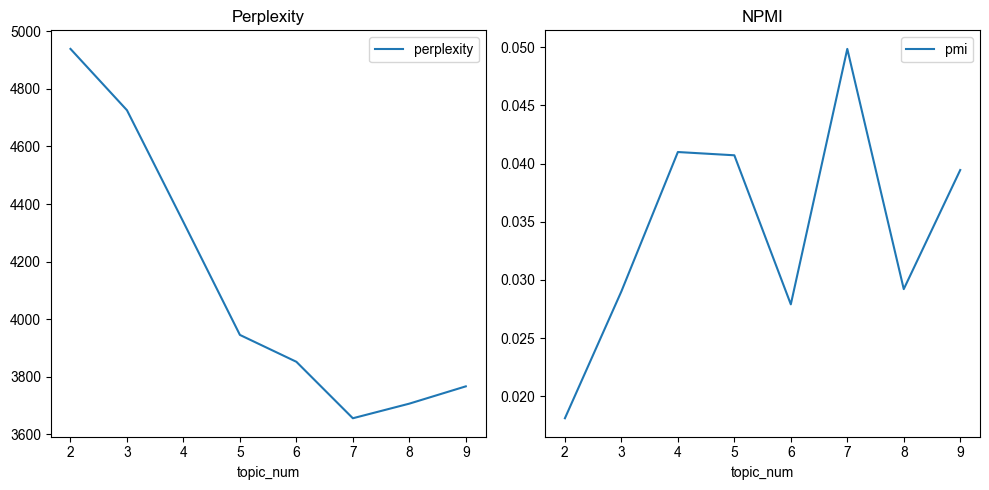

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

result.plot.line(x='topic_num', y='perplexity', ax=axs[0])
axs[0].set_title('Perplexity')

result.plot.line(x='topic_num', y='pmi', ax=axs[1])
axs[1].set_title("NPMI")

plt.tight_layout()
plt.show()

> 就訓練結果來看topic_num=7為最佳。 \
> `perplexity` 在 7 的時最低，`pmi` 在主題數 7 的時候最高，因此我們可以選擇主題數 7 作為最佳主題數。

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)
  

> 根據 perplecity 跟 PMI 的結果，我們選擇主題數 7 作為最佳主題數。

In [22]:
model_7 = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_7, corpus, dictionary)
p

2024-05-06 10:38:21,860 : INFO : using symmetric alpha at 0.14285714285714285
2024-05-06 10:38:21,861 : INFO : using symmetric eta at 0.14285714285714285
2024-05-06 10:38:21,863 : INFO : using serial LDA version on this node
2024-05-06 10:38:21,868 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 5987 documents, updating model once every 2000 documents, evaluating perplexity every 5987 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 10:38:21,869 : INFO : PROGRESS: pass 0, at document #2000/5987
2024-05-06 10:38:22,313 : INFO : merging changes from 2000 documents into a model of 5987 documents
2024-05-06 10:38:22,315 : INFO : topic #4 (0.143): 0.009*"表示" + 0.007*"今天" + 0.005*"美國" + 0.004*"今年" + 0.004*"拜登" + 0.004*"報導" + 0.003*"去年" + 0.003*"公司" + 0.003*"巨蛋" + 0.003*"總統"
2024-05-06 10:38:22,316 : INFO : topic #6 (0.143): 0.008*"美國" + 0.006*"中國" + 0.006*"表示" + 0.005*"今天" + 0.005*"以色列" + 0.004*"台灣" + 0.004*"報導" + 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.087822  0.000418       1        1  23.402379
6     -0.030032 -0.181958       2        1  18.648590
0      0.230465  0.109849       3        1  14.158879
1      0.207846  0.071276       4        1  13.755304
2     -0.208376  0.021177       5        1  11.604135
4     -0.007697 -0.172707       6        1   9.810538
5     -0.280028  0.151945       7        1   8.620174, topic_info=      Term         Freq        Total Category  logprob  loglift
1859    中國  5223.000000  5223.000000  Default  30.0000  30.0000
4693    億元  4061.000000  4061.000000  Default  29.0000  29.0000
2761    警方  1754.000000  1754.000000  Default  28.0000  28.0000
12514   營收  2091.000000  2091.000000  Default  27.0000  27.0000
90      市場  3597.000000  3597.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
2713    協助   219.880258   780.675636   Topic7  -6.0655   1.1840
4973    安全   232.164733  1437.939021   Topic7  -6.0112   0.6275
10815   檢方   202.563644   455.400549   Topic7  -6.1476   1.6409
316     前往   203.425423   495.354536   Topic7  -6.1433   1.5611
531     指出   220.953760  3397.744153   Topic7  -6.0607  -0.2818

[581 rows x 6 columns], token_table=       Topic      Freq Term
term                       
656        1  0.016705   一名
656        2  0.143661   一名
656        3  0.003341   一名
656        4  0.011693   一名
656        5  0.474414   一名
...      ...       ...  ...
17501      4  0.996386   高息
15730      5  0.977633  高虹安
15730      7  0.012534  高虹安
15410      5  0.980655   高院
13509      4  0.994786   點收

[1646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 1, 2, 3, 5, 6])

根據 LDAvis 的結果，主題一的圓面積比較大，推測這個主題的文章比較多，出現較多「國際、產業、投資、房價」等等的產經相關詞彙，\
從我們資料及的文章類別來看關於產經的新聞相較於其他的種類確實有比較大的數目。\

接著再看到「3,4」「2,6」的圓心距離接近，因此這兩個主題可能有相關性，把他們的詞彙拉出來看。

In [23]:
model_7.show_topics()

[(0,
  '0.018*"億元" + 0.013*"營收" + 0.011*"今年" + 0.011*"成長" + 0.010*"去年" + 0.009*"市場" + 0.007*"產品" + 0.006*"需求" + 0.006*"公司" + 0.006*"每股"'),
 (1,
  '0.010*"市場" + 0.009*"指數" + 0.009*"投資" + 0.008*"台股" + 0.007*"億元" + 0.006*"上漲" + 0.006*"今年" + 0.006*"投資人" + 0.005*"股價" + 0.005*"表現"'),
 (2,
  '0.006*"表示" + 0.006*"萬元" + 0.005*"網友" + 0.004*"發現" + 0.003*"發生" + 0.003*"認為" + 0.003*"指出" + 0.003*"今天" + 0.003*"公司" + 0.003*"調查"'),
 (3,
  '0.006*"台灣" + 0.006*"表示" + 0.005*"發展" + 0.005*"企業" + 0.005*"公司" + 0.004*"提供" + 0.004*"服務" + 0.003*"合作" + 0.003*"字頭" + 0.003*"國際"'),
 (4,
  '0.008*"今天" + 0.006*"台灣" + 0.005*"比賽" + 0.004*"巨蛋" + 0.004*"表示" + 0.004*"日本" + 0.004*"今年" + 0.004*"聯盟" + 0.003*"巨人" + 0.003*"去年"'),
 (5,
  '0.017*"警方" + 0.010*"男子" + 0.007*"發現" + 0.006*"分局" + 0.006*"記者" + 0.005*"駕駛" + 0.005*"毒品" + 0.005*"發生" + 0.005*"表示" + 0.004*"員警"'),
 (6,
  '0.022*"中國" + 0.011*"大陸" + 0.010*"美國" + 0.009*"表示" + 0.008*"報導" + 0.007*"國家" + 0.005*"工作" + 0.005*"經濟" + 0.005*"政府" + 0.005*"會議"')]

*主題 (3,4) 的詞彙：*\
3: ['億元', '營收', '今年', '成長', '去年', '市場', '產品', '需求', '公司', '每股']\
4: ['市場', '指數', '投資', '台股', '億元', '上漲', '今年', '投資人', '股價', '表現']

以上兩個主題的詞彙多關於市場、投資、股市等相關的詞彙，因此我們可以推測這兩個主題可能有相關性。

*主題 (2,6) 的詞彙：*\
2: ['中國', '大陸', '美國', '表示', '報導', '國家', '工作', '經濟', '政府', '會議']\
6: ['今天', '台灣', '比賽', '巨蛋', '表示', '日本', '今年', '聯盟', '巨人', '去年']

以上兩個主題重疊的部分都在國家的名稱比較多，推測由於體育新聞多關於外國選手或是國外賽事，與國際新聞相同都會提到較多次的國家名稱，\
導致這兩個主題的詞彙重疊。

> 試著繪製 topic=5 的結果

In [24]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-05-06 10:38:30,908 : INFO : using symmetric alpha at 0.2
2024-05-06 10:38:30,909 : INFO : using symmetric eta at 0.2
2024-05-06 10:38:30,910 : INFO : using serial LDA version on this node
2024-05-06 10:38:30,914 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 5987 documents, updating model once every 2000 documents, evaluating perplexity every 5987 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 10:38:30,914 : INFO : PROGRESS: pass 0, at document #2000/5987
2024-05-06 10:38:31,345 : INFO : merging changes from 2000 documents into a model of 5987 documents
2024-05-06 10:38:31,347 : INFO : topic #0 (0.200): 0.008*"美國" + 0.007*"表示" + 0.005*"報導" + 0.005*"中國" + 0.004*"今天" + 0.003*"拜登" + 0.003*"總統" + 0.003*"以色列" + 0.003*"公司" + 0.003*"指出"
2024-05-06 10:38:31,348 : INFO : topic #1 (0.200): 0.007*"表示" + 0.005*"今天" + 0.004*"美國" + 0.004*"中國" + 0.003*"日本" + 0.003*"今年" + 0.003*"市場" + 0.003*"美元" + 0.002*"報導" + 0.002*

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.098379  0.200432       1        1  26.345684
3      0.020138  0.005228       2        1  24.626242
2     -0.278305 -0.123326       3        1  19.153261
0      0.181540 -0.045972       4        1  16.505498
1      0.175007 -0.036362       5        1  13.369314, topic_info=      Term         Freq        Total Category  logprob  loglift
4693    億元  3962.000000  3962.000000  Default  30.0000  30.0000
12514   營收  2029.000000  2029.000000  Default  29.0000  29.0000
90      市場  3547.000000  3547.000000  Default  28.0000  28.0000
1859    中國  5638.000000  5638.000000  Default  27.0000  27.0000
2761    警方  1744.000000  1744.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
458     今年   738.361689  4130.522091   Topic5  -5.2930   0.2905
942     持續   624.158507  2574.018567   Topic5  -5.4611   0.5954
390     美國   632.037648  3377.416096   Topic5  -5.4485   0.3363
616     表示   681.136870  6773.132785   Topic5  -5.3737  -0.2847
933     成長   509.844648  2475.917210   Topic5  -5.6634   0.4319

[429 rows x 6 columns], token_table=       Topic      Freq Term
term                       
656        1  0.155579   一名
656        2  0.034757   一名
656        3  0.781205   一名
656        4  0.008275   一名
656        5  0.019861   一名
...      ...       ...  ...
9806       5  0.003704   駕駛
17501      2  0.003791   高息
17501      4  0.003791   高息
17501      5  0.993203   高息
13509      5  0.989423   點收

[1070 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

In [25]:
model_5.show_topics()

[(0,
  '0.016*"億元" + 0.011*"營收" + 0.011*"今年" + 0.010*"成長" + 0.009*"市場" + 0.009*"去年" + 0.006*"產品" + 0.006*"表示" + 0.006*"需求" + 0.006*"公司"'),
 (1,
  '0.010*"市場" + 0.010*"指數" + 0.009*"投資" + 0.008*"台股" + 0.007*"上漲" + 0.006*"億元" + 0.006*"投資人" + 0.005*"股價" + 0.005*"今年" + 0.005*"表現"'),
 (2,
  '0.008*"警方" + 0.006*"男子" + 0.006*"表示" + 0.005*"發現" + 0.005*"發生" + 0.004*"萬元" + 0.003*"記者" + 0.003*"今天" + 0.003*"調查" + 0.003*"分局"'),
 (3,
  '0.006*"表示" + 0.006*"台灣" + 0.005*"發展" + 0.005*"企業" + 0.005*"公司" + 0.004*"提供" + 0.004*"服務" + 0.003*"合作" + 0.003*"透過" + 0.003*"國際"'),
 (4,
  '0.015*"中國" + 0.008*"美國" + 0.008*"表示" + 0.006*"大陸" + 0.006*"報導" + 0.005*"國家" + 0.005*"今天" + 0.004*"台灣" + 0.004*"工作" + 0.003*"會議"')]

從上圖來看，主題(4,5)還是有重疊的情況，看一下裡面的詞彙。

*主題 (4,5) 的詞彙：*

4: `['億元', '營收', '今年', '成長', '市場', '去年', '產品', '表示', '需求', '公司']`\
5: `['市場', '指數', '投資', '台股', '上漲', '億元', '投資人', '股價', '今年', '表現']`

詞彙涵蓋了股市投資相關的主題，包括市場、指數、投資、台股、股價、今年、億元等。\
得以推測，這兩個主題可能都與股市的表現、投資趨勢等相關。

> 試著繪製 topic=4 的結果

In [26]:
model_4 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 7 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary)
p

2024-05-06 10:38:39,179 : INFO : using symmetric alpha at 0.25
2024-05-06 10:38:39,180 : INFO : using symmetric eta at 0.25
2024-05-06 10:38:39,181 : INFO : using serial LDA version on this node
2024-05-06 10:38:39,184 : INFO : running online (multi-pass) LDA training, 4 topics, 7 passes over the supplied corpus of 5987 documents, updating model once every 2000 documents, evaluating perplexity every 5987 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-06 10:38:39,184 : INFO : PROGRESS: pass 0, at document #2000/5987
2024-05-06 10:38:39,606 : INFO : merging changes from 2000 documents into a model of 5987 documents
2024-05-06 10:38:39,608 : INFO : topic #0 (0.250): 0.008*"美國" + 0.007*"表示" + 0.005*"報導" + 0.004*"今天" + 0.004*"中國" + 0.004*"拜登" + 0.003*"總統" + 0.003*"公司" + 0.003*"以色列" + 0.003*"指出"
2024-05-06 10:38:39,608 : INFO : topic #1 (0.250): 0.007*"表示" + 0.005*"今天" + 0.004*"美國" + 0.003*"今年" + 0.003*"中國" + 0.003*"日本" + 0.003*"報導" + 0.002*"市場" + 0.002*"指數" + 0.00

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.025286 -0.120403       1        1  32.526731
2      0.266523  0.028839       2        1  27.501140
0     -0.179517 -0.083902       3        1  24.181068
1     -0.112292  0.175466       4        1  15.791061, topic_info=      Term         Freq        Total Category  logprob  loglift
4693    億元  4150.000000  4150.000000  Default  30.0000  30.0000
4018    指數  1683.000000  1683.000000  Default  29.0000  29.0000
12514   營收  2121.000000  2121.000000  Default  28.0000  28.0000
90      市場  3806.000000  3806.000000  Default  27.0000  27.0000
1859    中國  4780.000000  4780.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
616     表示   735.634179  6695.348766   Topic4  -5.4632  -0.3627
942     持續   542.942792  2659.608335   Topic4  -5.7669   0.2568
546     新高   474.767200  1132.810024   Topic4  -5.9011   0.9761
4693    億元   539.865885  4150.003043   Topic4  -5.7726  -0.1938
866     台灣   505.554492  3417.579741   Topic4  -5.8383  -0.0653

[332 rows x 6 columns], token_table=       Topic      Freq Term
term                       
656        1  0.086732   一名
656        2  0.870473   一名
656        3  0.006308   一名
656        4  0.034693   一名
4750       4  0.984900   一檔
...      ...       ...  ...
9806       4  0.001734   駕駛
17501      3  0.003306   高息
17501      4  0.995067   高息
13109      4  0.994634   鮑爾
13509      4  0.992320   點收

[665 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [27]:
model_4.print_topics(num_words=20)

2024-05-06 10:38:49,545 : INFO : topic #0 (0.250): 0.013*"億元" + 0.009*"今年" + 0.008*"市場" + 0.008*"營收" + 0.008*"成長" + 0.007*"去年" + 0.006*"表示" + 0.006*"公司" + 0.005*"產品" + 0.005*"需求" + 0.005*"持續" + 0.005*"產業" + 0.004*"客戶" + 0.004*"全球" + 0.004*"第季" + 0.004*"指出" + 0.004*"每股" + 0.004*"營運" + 0.004*"獲利" + 0.003*"現金"
2024-05-06 10:38:49,546 : INFO : topic #1 (0.250): 0.010*"指數" + 0.008*"台股" + 0.007*"市場" + 0.007*"投資" + 0.006*"美國" + 0.006*"上漲" + 0.005*"投資人" + 0.005*"股價" + 0.005*"表現" + 0.004*"今年" + 0.004*"表示" + 0.004*"美元" + 0.004*"基金" + 0.004*"經濟" + 0.004*"降息" + 0.004*"今天" + 0.004*"利率" + 0.004*"外資" + 0.004*"股息" + 0.003*"預期"
2024-05-06 10:38:49,546 : INFO : topic #2 (0.250): 0.006*"表示" + 0.006*"警方" + 0.005*"今天" + 0.004*"男子" + 0.004*"發現" + 0.004*"發生" + 0.004*"記者" + 0.003*"萬元" + 0.003*"指出" + 0.003*"報導" + 0.002*"調查" + 0.002*"拜登" + 0.002*"造成" + 0.002*"認為" + 0.002*"現場" + 0.002*"以色列" + 0.002*"分局" + 0.002*"總統" + 0.002*"當時" + 0.002*"美國"
2024-05-06 10:38:49,547 : INFO : topic #3 (0.250): 0.011*"中國" + 0.007*"

[(0,
  '0.013*"億元" + 0.009*"今年" + 0.008*"市場" + 0.008*"營收" + 0.008*"成長" + 0.007*"去年" + 0.006*"表示" + 0.006*"公司" + 0.005*"產品" + 0.005*"需求" + 0.005*"持續" + 0.005*"產業" + 0.004*"客戶" + 0.004*"全球" + 0.004*"第季" + 0.004*"指出" + 0.004*"每股" + 0.004*"營運" + 0.004*"獲利" + 0.003*"現金"'),
 (1,
  '0.010*"指數" + 0.008*"台股" + 0.007*"市場" + 0.007*"投資" + 0.006*"美國" + 0.006*"上漲" + 0.005*"投資人" + 0.005*"股價" + 0.005*"表現" + 0.004*"今年" + 0.004*"表示" + 0.004*"美元" + 0.004*"基金" + 0.004*"經濟" + 0.004*"降息" + 0.004*"今天" + 0.004*"利率" + 0.004*"外資" + 0.004*"股息" + 0.003*"預期"'),
 (2,
  '0.006*"表示" + 0.006*"警方" + 0.005*"今天" + 0.004*"男子" + 0.004*"發現" + 0.004*"發生" + 0.004*"記者" + 0.003*"萬元" + 0.003*"指出" + 0.003*"報導" + 0.002*"調查" + 0.002*"拜登" + 0.002*"造成" + 0.002*"認為" + 0.002*"現場" + 0.002*"以色列" + 0.002*"分局" + 0.002*"總統" + 0.002*"當時" + 0.002*"美國"'),
 (3,
  '0.011*"中國" + 0.007*"表示" + 0.007*"大陸" + 0.006*"台灣" + 0.005*"發展" + 0.004*"工作" + 0.004*"國家" + 0.004*"美國" + 0.004*"政府" + 0.004*"經濟" + 0.004*"指出" + 0.004*"企業" + 0.003*"提供" + 0.003*"國際" + 0

* 主題一：`市場、營收、成長、去年、公司、需求、產品、持續、產業、客戶、第季、指出、營運、主要`
* 主題二：`指數、台股、市場、投資、美國、上漲、投資人、股價、表現、表示、今年、經濟、美元、降息、基金、利率、外資、股息、億元`
* 主題三：`表示、警方、今天、男子、發現、發生、記者、萬元、報導、指出、調查、認為、造成、現場、拜登、分局、以色列、當時、安全、總統`
* 主題四：`中國、表示、大陸、台灣、發展、工作、國家、政府、指出、美國、企業、經濟、提供、公司、國際、合作、問題、報告、會議、服務`

使用 ChatGPT 對於主題模型的解釋，可分為以下幾個主提：

1. **經濟與企業**\
詞彙解釋：市場、營收、成長、公司、需求、產品、產業、客戶、指出、營運\
可能的主題類別：這個主題很可能涉及到經濟狀況、企業營運情況，例如市場表現、公司營收、產品需求等。

2. **金融投資**\
詞彙解釋：指數、台股、市場、投資、美國、上漲、投資人、股價、表現、表示、降息、基金、利率、外資、股息、億元\
可能的主題類別：這個主題可能與金融市場相關，包括股票、基金、投資等金融領域的議題。

3. **新聞事件報導**\
詞彙解釋：表示、警方、今天、男子、發現、發生、記者、報導、指出、調查、認為、造成、現場、拜登、分局、以色列、當時、安全、總統\
可能的主題類別：這個主題很可能是關於新聞事件的報導，涉及警方、事件發生地點、人物、調查等內容。

4. **國際關係與政治**\
詞彙解釋：中國、大陸、台灣、發展、工作、國家、政府、指出、美國、企業、經濟、提供、公司、國際、合作、問題、報告、會議、服務\
可能的主題類別：這個主題可能涉及到國際關係、政治議題，包括各國間的合作、經濟發展、企業活動等。

## 小結
最初的資料集共有六個主題，使用topic=6的參數下去訓練並沒有得到比較好的結果，對於主題的切分並不是很明顯，\
接著透過 （perplexity, pmi） 這兩個指標來找出最佳的主題數，之後再透過 LDAvis 來看各個主題的分佈，進而找出最佳的主題數。

首先以指標所顯示的最佳主題數 7 作為主題數，透過 LDAvis 來看各個主題的分佈，\
發現主題一的圓面積比較大，推測這個主題的文章比較多，出現較多「國際、產業、投資、房價」等等的產經相關詞彙，\
而主題(3,4)、(2,6)、(4,5)的圓心距離接近，並且有高度重疊，推測這些主題仍有相關性，並沒有做到最好的區隔。

測試了topic=5的結果，發現主題(4,5)還是有重疊的情況，因此我們可以推測這兩個主題可能都與股市的表現、投資趨勢等相關。\
可能是「產經」與「股市」這兩個主題本就相近容易形成重疊。

看到在主題數＝4 的情況下，各個主題的圓圈並不重疊，代表說在這個主題數下，各個主題是相對獨立的。\

> 📣 發現：\
> 當我們使用較少的主題數訓練模型，原先資料筆數較低的新聞種類就容易被吃掉，\
> 例如：**「運動」主題的資料筆數只有其他類別的一半**，在主題數 4 的情況下，幾乎沒有被切分出來，\
> 這樣的情況下，我們可以透過增加主題數來讓模型更細緻的切分主題。\
> 這也是主題模型的一個重要的調整參數。

In [28]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

In [29]:
import guidedlda

In [30]:
word2id = dictionary.token2id

根據前面的LDA模型結果提供的主題以及主題字，在這邊提供給guidedLDA，讓模型可以更好的學習，進而產生更好的主題模型。

In [31]:
seed_topic_list = [
        ['市場', '營收', '成長', '去年', '公司', '需求', '產品', '持續', '產業', '客戶', '第季', '指出', '營運', '主要'],
        ['指數', '台股', '市場', '投資', '美國', '上漲', '投資人', '股價', '表現', '表示', '今年', '經濟', '美元', '降息', '基金', '利率', '外資', '股息', '億元'],
        ['表示', '警方', '今天', '男子', '發現', '發生', '記者', '萬元', '報導', '指出', '調查', '認為', '造成', '現場', '拜登', '分局', '以色列', '當時', '安全', '總統'],
        ['中國', '表示', '大陸', '台灣', '發展', '工作', '國家', '政府', '指出', '美國', '企業', '經濟', '提供', '公司', '國際', '合作', '問題', '報告', '會議', '服務']
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [32]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

> 用 topic=4 下去跑

In [33]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-06 10:38:50,276 : INFO : n_documents: 5987
2024-05-06 10:38:50,276 : INFO : vocab_size: 19653
2024-05-06 10:38:50,277 : INFO : n_words: 1098743
2024-05-06 10:38:50,277 : INFO : n_topics: 4
2024-05-06 10:38:50,277 : INFO : n_iter: 100
2024-05-06 10:38:53,980 : INFO : <0> log likelihood: -11313916
2024-05-06 10:38:54,598 : INFO : <20> log likelihood: -9523168
2024-05-06 10:38:55,189 : INFO : <40> log likelihood: -9464635
2024-05-06 10:38:55,777 : INFO : <60> log likelihood: -9442404
2024-05-06 10:38:56,361 : INFO : <80> log likelihood: -9421620
2024-05-06 10:38:56,940 : INFO : <99> log likelihood: -9406763


In [35]:
vocab = tuple(dictionary.token2id.keys())

In [36]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 表示 台灣 公司 企業 發展 提供 產業 服務 市場 未來
Topic 1: 億元 市場 今年 成長 營收 去年 投資 指數 預期 持續
Topic 2: 警方 今天 表示 男子 發現 記者 發生 萬元 比賽 分局
Topic 3: 中國 美國 表示 大陸 報導 國家 經濟 政府 拜登 工作


/opt/anaconda3/envs/DL/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.060980  0.244606       1        1  28.220637
0     -0.080651 -0.075951       2        1  25.201140
2      0.268838 -0.121745       3        1  25.054191
1     -0.249167 -0.046909       4        1  21.524031, topic_info=      Term         Freq        Total Category  logprob  loglift
4693    億元  3792.000000  3792.000000  Default  30.0000  30.0000
1859    中國  4309.000000  4309.000000  Default  29.0000  29.0000
90      市場  3668.000000  3668.000000  Default  28.0000  28.0000
12514   營收  1915.000000  1915.000000  Default  27.0000  27.0000
390     美國  3670.000000  3670.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
616     表示  1122.090749  6943.184502   Topic4  -5.3507  -0.2866
2107    全球   825.333862  1993.582468   Topic4  -5.6579   0.6541
390     美國   832.328132  3670.543459   Topic4  -5.6495   0.0521
764     目前   790.362511  2440.261686   Topic4  -5.7012   0.4086
531     指出   795.358418  3414.618582   Topic4  -5.6949   0.0790

[293 rows x 6 columns], token_table=       Topic      Freq Term
term                       
656        1  0.233593   一名
656        2  0.006313   一名
656        3  0.760754   一名
17515      2  1.000530   一坪
10038      2  0.058104   上漲
...      ...       ...  ...
7189       1  0.953113   香港
7189       3  0.011044   香港
7189       4  0.035341   香港
9806       2  0.060418   駕駛
9806       3  0.940252   駕駛

[472 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

```
Topic 0: 表示 台灣 公司 企業 發展 提供 產業 服務 市場 未來

Topic 1: 億元 市場 今年 成長 營收 去年 投資 指數 預期 持續

Topic 2: 警方 今天 表示 男子 發現 記者 發生 萬元 比賽 分局

Topic 3: 中國 美國 表示 大陸 報導 國家 經濟 政府 拜登 工作
```


使用生成式AI模型ChatGPT對於guidedLDA產生的主題模型的解釋：

1. **企業發展與市場前景**

    主題關鍵詞：表示、台灣、公司、企業、發展、提供、產業、服務、市場、未來\
    主題解釋：這個主題可能涉及到台灣企業的發展狀況，以及未來市場的趨勢。台灣企業可能在提供各種產業服務方面發揮著重要作用，並致力於擴大其市場份額。

2. **經濟成長與投資趨勢**

    主題關鍵詞：億元、市場、今年、成長、營收、去年、投資、指數、預期、持續\
    主題解釋：這個主題可能討論了市場的成長與營收情況，以及投資者對未來的預期。詞彙中的「億元」可能指涉到龐大的金額，而「指數」可能指代股市或其他金融市場的指數。

3. **警方報導與事件發生**

    主題關鍵詞：警方、今天、表示、男子、發現、記者、發生、萬元、比賽、分局\
    主題解釋：這個主題可能是關於警方報導的新聞事件，可能包括了今天發生的事情、警方對事件的說法、記者的報導、事件的發現以及與事件相關的地點或人物。

4. **中美關係與國家政策**

    主題關鍵詞：中國、美國、表示、大陸、報導、國家、經濟、政府、拜登、工作\
    主題解釋：這個主題可能討論了中美兩國之間的關係、國家的經濟狀況以及政府的政策與工作。「拜登」可能指涉到美國的政治人物，而「報導」可能指涉到媒體對於相關事件或情況的報導。

使用 ChatGPT 對於前面普通LDAModel主題模型的解釋：

1. **經濟與企業**\
    詞彙解釋：市場、營收、成長、公司、需求、產品、產業、客戶、指出、營運\
    可能的主題類別：這個主題很可能涉及到經濟狀況、企業營運情況，例如市場表現、公司營收、產品需求等。

2. **金融投資**\
    詞彙解釋：指數、台股、市場、投資、美國、上漲、投資人、股價、表現、表示、降息、基金、利率、外資、股息、億元\
    可能的主題類別：這個主題可能與金融市場相關，包括股票、基金、投資等金融領域的議題。

3. **新聞事件報導**\
    詞彙解釋：表示、警方、今天、男子、發現、發生、記者、報導、指出、調查、認為、造成、現場、拜登、分局、以色列、當時、安全、總統\
    可能的主題類別：這個主題很可能是關於新聞事件的報導，涉及警方、事件發生地點、人物、調查等內容。

4. **國際關係與政治**\
    詞彙解釋：中國、大陸、台灣、發展、工作、國家、政府、指出、美國、企業、經濟、提供、公司、國際、合作、問題、報告、會議、服務\
    可能的主題類別：這個主題可能涉及到國際關係、政治議題，包括各國間的合作、經濟發展、企業活動等。

### 小結
透過 GuidedLDA 所生成的主題模型，可以看到主題的切分相對於普通的 LDA 模型更加清晰，\
但是在這個案例中，GuidedLDA 並沒有比普通的 LDA 模型表現得更好，\
推測可能的原因是在這個案例中topic=4的情況，主題的切分並不是很困難，普通的 LDA 模型已經可以得到不錯的結果，\
因此 GuidedLDA 並沒有帶來太大的改進。

我們從聯合新聞爬下來的新聞種類有
* 【體育】
* 【社會】
* 【國際】
* 【產經】
* 【股市】
* 【兩岸】

這邊我們可以看到主題的分類大致上也是符合部分種類的，例如經濟與企業、金融投資、新聞事件報導、國際關係與政治等主題。

但是如「體育」、「產經」、「兩岸」這些類別的主題就被概括到了其他主題中，這也是主題模型分類類別太少的問題。


# 2nd. Classification with Embeddings
```python

In [37]:
import pandas as pd
import re
import jieba

from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, models, util
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [38]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

2024-05-06 10:40:42,160 : INFO : Load pretrained SentenceTransformer: google-bert/bert-base-chinese
2024-05-06 10:40:42,596 : WARNING : No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with MEAN pooling.
/opt/anaconda3/envs/DL/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-05-06 10:40:43,897 : INFO : Use pytorch device_name: mps


0

## 使用 udn 資料訓練模型

In [39]:
udn = pd.read_csv("./raw_data/udn_news_202402.csv")

In [40]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,中職非樹倒猢猻散而是桃李滿天下戰力外溢彰顯樂天深度由於過去幾年在季後的休賽期間總是在人員調動...,https://udn.com/news/story/122629/7746474,運動
1,中職驚奇一年味全龍紅色大砲劉基鴻轟出神劇本撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕...,https://udn.com/news/story/122629/7748599,運動
2,中職花店老闆上工前中信兄弟轉運手官大元展開第人生撰文鍾亞芳生涯中大半時間都在思索褪下球員身分...,https://udn.com/news/story/122629/7748779,運動
3,中職冬盟展現打擊天賦統一獅何恆佑潛力股衝刺一軍撰文鄧心瑜何恆佑是教練團公認訓練認真態度積極選...,https://udn.com/news/story/122629/7748904,運動
4,尼克無懼逆境加速向前衝攻防都進入精英級別紐約尼克最近八連勝勝敗站上東區第三尼克進攻效率第六防...,https://udn.com/news/story/122629/7749189,運動


In [ ]:
udn["embeddings"] = udn.content.apply(lambda x: bert_ch.encode(x))
udn.head(3)

,content,artUrl,artCatagory,embeddings
0,中職非樹倒猢猻散而是桃李滿天下戰力外溢彰顯樂天深度由於過去幾年在季後的休賽期間總是在人員調動...,https://udn.com/news/story/122629/7746474,運動,"[0.2598603, -0.103336915, -0.13030407, 0.32271..."
1,中職驚奇一年味全龍紅色大砲劉基鴻轟出神劇本撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕...,https://udn.com/news/story/122629/7748599,運動,"[0.38988382, 0.0138491485, -0.1023845, 0.16257..."
2,中職花店老闆上工前中信兄弟轉運手官大元展開第人生撰文鍾亞芳生涯中大半時間都在思索褪下球員身分...,https://udn.com/news/story/122629/7748779,運動,"[0.486182, -0.15005, 0.0047927666, 0.27161482,..."


In [ ]:
import numpy as np
from ast import literal_eval

In [ ]:
data = udn.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

# print(X_train.head())
# print(y_train.head())

           0         1         2         3         4         5         6    \
2139  0.419848 -0.011116 -0.354665  0.067184 -0.004627 -0.040697 -0.055878   
1916  0.376304  0.039414 -0.362329 -0.045580  0.104265 -0.096845 -0.315971   
258   0.480350  0.020603 -0.117614  0.065926  0.057779 -0.239893  0.021462   
2803  0.124938 -0.156221 -0.432256  0.209314  0.108994 -0.008472 -0.243737   
2089  0.427623 -0.042018 -0.351605  0.131566 -0.150872  0.191713  0.023241   

           7         8         9    ...       758       759       760  \
2139 -0.024846 -0.115148 -0.406072  ...  0.175395 -0.039127  0.211727   
1916  0.175212 -0.213346 -0.079264  ... -0.091282 -0.340814  0.215514   
258  -0.129073 -0.147012 -0.332668  ...  0.039450 -0.261836  0.050737   
2803  0.005351 -0.214306 -0.282695  ...  0.045290 -0.246024  0.114624   
2089 -0.288580 -0.281559 -0.295655  ...  0.172586 -0.029071  0.107264   

           761       762       763       764       765       766       767  
2139  0.026978 

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

/opt/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

['兩岸' '運動' '運動' '運動' '兩岸' '股市' '全球' '全球' '全球' '全球']


In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.93      0.95      0.94       451
          兩岸       0.96      0.93      0.95       518
          股市       0.98      0.99      0.98       616
          運動       0.99      0.98      0.99       375

    accuracy                           0.97      1960
   macro avg       0.97      0.96      0.97      1960
weighted avg       0.97      0.97      0.97      1960



## 讀取驗證用的00940資料集

In [ ]:
cat_dict = {
    'Stock': '股市'
}

In [ ]:
# define preprocess pipeline
def preprocess(df: pd.DataFrame, cols = None) -> pd.DataFrame:
    colNames = list(df)
    df["artContent"] = df.artContent.apply(
        lambda x: re.sub("(http|https)://.*", "", x)
    )
    df["artTitle"] = df["artTitle"].apply(
        lambda x: re.sub("(http|https)://.*", "", x)
    )
    # 只留下中文字
    df["artContent"] = df.artContent.apply(
        lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
    )
    df["artTitle"] = df["artTitle"].apply(
        lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
    )
    df['artCatagory'] = df['artCatagory'].map(cat_dict)
    df['content'] = df['artTitle'] + df['artContent']
    if 'artComment' in colNames:
        df["artComment"] = df["artComment"].apply(
            lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
        )
        df['content'] += df['artComment']
        df = df.drop(columns=['artComment'])
        
    df = df.drop(columns=['artTitle', 'artContent'])
    df = df.dropna()
    return df

In [ ]:
df_940 = pd.read_csv("./raw_data/ptt_00940_article.csv")
df_940.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26 19:53:36,MikeShiver,Stock,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""abc0922001"",...",180.217.136.24,2024-01-27 02:04:03,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,kiversonx17,Stock,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SuGK"", ""cmtC...",118.165.210.174,2024-01-28 02:04:10,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,[請益]00940的選股邏輯,2024-02-18 17:39:12,humbler,Stock,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""apeople"", ""c...",111.251.198.167,2024-02-19 02:05:29,ptt


In [ ]:
df_940 = df_940.drop(['system_id', 'artUrl', 'artDate', 'artPoster', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
df_940.head()

,artTitle,artCatagory,artContent,artComment
0,[新聞]元大臺灣價值高息ETF准募3／11展開募集,Stock,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""abc0922001"",..."
1,[新聞]元大加入月配息ETF戰場！00940發行價10,Stock,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SuGK"", ""cmtC..."
2,[請益]00940的選股邏輯,Stock,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""apeople"", ""c..."
3,[標的]2603長榮高股息送錢多多多,Stock,1. 標的：2603長榮\n\n2. 分類：多\n\n3. 分析/正文：紅海至少再亂個幾個月...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""vvnews"", ""cm..."
4,Re:[標的]2603長榮高股息送錢多多多,Stock,https://i.imgur.com/O71Mm0G.jpg\n本來打算$147買長榮 結...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""Cheng0810"", ..."


In [ ]:
df_940 = preprocess(df_940)
df_940.head(3)

,artCatagory,content
0,股市,新聞元大臺灣價值高息准募展開募集原文標題元大臺灣價值高息准募展開募集原文連結發布時間記者署名...
1,股市,新聞元大加入月配息戰場發行價原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發...
2,股市,請益的選股邏輯元大新募集的高股息除了發行價元驚人低之外選股邏輯納入本益比自由現金流股東權益報...


In [ ]:
df_940["embeddings"] = df_940.content.apply(lambda x: bert_ch.encode(x))
df_940.head(3)

,artCatagory,content,embeddings
0,股市,新聞元大臺灣價值高息准募展開募集原文標題元大臺灣價值高息准募展開募集原文連結發布時間記者署名...,"[0.46057558, 0.15931085, -0.29422402, 0.048844..."
1,股市,新聞元大加入月配息戰場發行價原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發...,"[0.41123766, 0.18158676, -0.252609, 0.05145976..."
2,股市,請益的選股邏輯元大新募集的高股息除了發行價元驚人低之外選股邏輯納入本益比自由現金流股東權益報...,"[0.41199562, 0.25616938, -0.17547035, 0.231156..."


### 進行驗證

In [ ]:
X_940 = df_940["embeddings"].apply(pd.Series)
y_940 = df_940["artCatagory"]

y_pred_940 = clf.predict(X_940)
y_pred_proba_940 = clf.predict_proba(X_940)
print(y_pred_940[:10])

print(classification_report(y_940, y_pred_940, zero_division=0))

['股市' '股市' '股市' '股市' '股市' '股市' '股市' '股市' '股市' '股市']
              precision    recall  f1-score   support

          兩岸       0.00      0.00      0.00         0
          股市       1.00      0.99      0.99       177

    accuracy                           0.99       177
   macro avg       0.50      0.49      0.50       177
weighted avg       1.00      0.99      0.99       177



### 以下為之前使用 DTM 作為訓練資料的結果

In [ ]:
# # 驗證模型
# X = df_940['words']
# y = df_940['artCatagory']

# y_pred = model_set['clf_mlp'].predict(vectorizer.transform(X).toarray())
# print(classification_report(y, y_pred, zero_division=1))

              precision    recall  f1-score   support

          國際       0.00      1.00      0.00         0
          社會       0.00      1.00      0.00         0
          股市       1.00      0.88      0.94       195
          體育       0.00      1.00      0.00         0

    accuracy                           0.88       195
   macro avg       0.25      0.97      0.23       195
weighted avg       1.00      0.88      0.94       195



```
使用 embeddings + 分類器
              precision    recall  f1-score   support
          股市       1.00      *0.99     *0.99       177

使用 DTM + 分類器
              precision    recall  f1-score   support
          股市       1.00      0.88      0.94       195
```

### 小結
從上述的結果來看，\
使用 embeddings + 分類器的結果比使用 DTM + 分類器的結果好，這也是因為 embeddings 可以更好的表達詞彙之間的關係，\
進而提升模型的表現。